In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Find the index where consecutive indicies are below the threshold
def find_threshold_index(arr, threshold=1e-3, consecutive=2):
    for i in range(len(arr[0]) - consecutive + 1):
        if np.all(arr[0, i:i+consecutive] < threshold):
            return i
    return -1

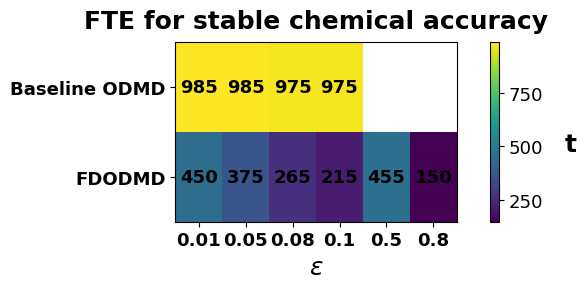

In [3]:
# Noise parameters
noise_values = [0.8, 0.5, 0.1, 0.08, 0.05, 0.01]
noise_sorted = sorted(noise_values)
n_noise = len(noise_sorted)

# Methods
methods = ["FDODMD", "Baseline ODMD"]
n_methods = len(methods)

# Initialize (noise, method) array
index_matrix = np.empty((n_noise, n_methods))

for i, noise in enumerate(noise_sorted):
    # Load the data
    filename_denoising = f"Cr2_fourier_denoised_odmd_6_stacked_denoised_noise={noise}_Tmax=1500_overlap=0.2_dt=1.0_tol={noise}-{noise}_real_ODMD.npy"
    filename_baseline = f"Cr2_baseline_odmd_noise={noise}_Tmax=1500_overlap=0.2_dt=1.0_real_ODMD.npy"
    
    # Load the "denoising" data and find the threshold index.
    try:
        data_denoising = np.load(filename_denoising)
        idx_denoising = find_threshold_index(data_denoising)
    except Exception as e:
        print(f"Error loading {filename_denoising}: {e}")
        idx_denoising = np.nan
    
    # Load the "baseline" data and find the threshold index.
    try:
        data_baseline = np.load(filename_baseline)
        if noise == 0.1:
            idx_baseline = find_threshold_index(data_baseline[2,:].reshape(1, 297))
        else:
            idx_baseline = find_threshold_index(data_baseline)
    except Exception as e:
        print(f"Error loading {filename_baseline}: {e}")
        idx_baseline = np.nan
    
    # We used 'step = 5' previously
    index_matrix[i, 0] = idx_denoising * 5
    index_matrix[i, 1] = idx_baseline * 5

# Noise on x-axis
index_matrix_T = index_matrix.T

# Mask out non-converging values
masked_matrix_T = np.ma.masked_where(index_matrix_T <= 0, index_matrix_T)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
cmap = plt.cm.viridis.copy()
cmap.set_bad('white')  # Set masked values to display as white

im = ax.imshow(masked_matrix_T, cmap=cmap, origin='lower', aspect='auto')

# Set x-axis ticks and labels for the noise values
ax.set_xticks(np.arange(n_noise))
ax.set_xticklabels([str(noise) for noise in noise_sorted], fontsize=13, fontweight='bold')

# Set y-axis ticks and labels for the two methods
ax.set_yticks(np.arange(n_methods))
ax.set_yticklabels(methods, fontsize=13, fontweight='bold')

# Label the axes and add a title
ax.set_xlabel(r"$\epsilon$", fontsize=18, fontweight='bold')
#ax.set_ylabel("Method", fontsize=18, fontweight='bold')
ax.set_title("FTE for stable chemical accuracy", fontsize=18, fontweight='bold', pad=10)


cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.1)
cbar.ax.yaxis.set_ticks_position('right')
cbar.ax.yaxis.set_label_position('right')
cbar.ax.set_ylabel("t", rotation=0, labelpad=20, fontsize=18, fontweight='bold')
cbar.ax.tick_params(labelsize=13)
# Annotate the heatmap with numerical values in bold black text
for i in range(masked_matrix_T.shape[0]):
    for j in range(masked_matrix_T.shape[1]):
        # Only annotate cells that are not masked
        if not np.ma.is_masked(masked_matrix_T[i, j]):
            ax.text(j, i, f"{masked_matrix_T[i, j]:.0f}", 
                    ha="center", va="center", color="black", 
                    fontweight="bold", fontsize=13)

plt.tight_layout()
plt.subplots_adjust(right=0.85)

#|plt.savefig('testheatmap_transposed_styled.pdf', bbox_inches='tight')
plt.show()